# This is a SUPER rough draft as I put code vomit on a page; check back in a week it'll be nice and pretty (if not, @ me)

In [17]:
# https://github.com/dashee87/cryptory

In [18]:
import pandas as pd
import time
import datetime
import numpy as np
from fbprophet import Prophet

## Pulling Historical Price Data for Ethereum

There are plenty of great ways

In [19]:
# load package
from cryptory import Cryptory

# initialise object 
# pull data from start of 2017 to present day
my_cryptory = Cryptory(from_date = "2015-01-01")

# get historical ethereum OHLC data from coinmarketcap
eth_ohlc_hist_df = my_cryptory.extract_coinmarketcap("ethereum")

# inspect the results
eth_ohlc_hist_df.head()

,date,open,high,low,close,volume,marketcap
0,2019-03-22,136.56,138.79,136.23,137.18,4490899266,14451740115
1,2019-03-21,140.48,141.00,135.86,136.64,5087247796,14392427839
2,2019-03-20,140.48,140.95,138.31,140.69,4664134462,14817151375
3,2019-03-19,139.25,140.99,139.14,140.52,4251488129,14797612389
4,2019-03-18,140.10,142.27,138.84,139.37,4551739879,14675181094


In [20]:
# subset to just the date and the closing price
eth_price_hist_df = my_cryptory.extract_coinmarketcap("ethereum").loc[:,['date','close']]

eth_price_hist_df = eth_price_hist_df.loc[eth_price_hist_df['date']>='01OCT2018',:]
# rename dt column to ds and continous value column to y per fbprophet's docs
eth_price_hist_df.columns = ['ds', 'y']

In [21]:
saturating_min = 0
saturating_max = 300

# eth_price_hist_df.loc[:,'floor'] = saturating_min
# eth_price_hist_df.loc[:,'cap'] = saturating_max

In [22]:
m = Prophet(
)
m.fit(eth_price_hist_df)

/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/pauljeffries/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
# Python
future = m.make_future_dataframe(periods=30)
# future.loc[:,'floor'] = saturating_min
# future.loc[:,'cap'] = saturating_max
future.tail()

,ds
198,2019-04-17
199,2019-04-18
200,2019-04-19
201,2019-04-20
202,2019-04-21


In [24]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
198,2019-04-17,141.691134,118.561997,166.123185
199,2019-04-18,138.022659,112.473384,163.286186
200,2019-04-19,140.104090,115.461555,163.963938
201,2019-04-20,142.032840,117.922047,168.121166
202,2019-04-21,142.648111,118.611697,165.876601


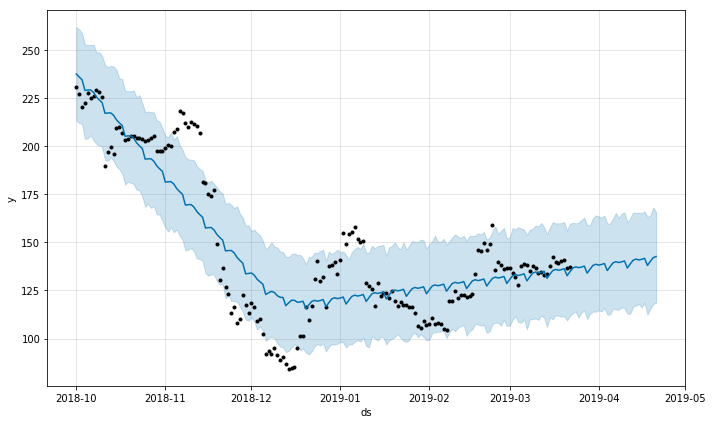

In [25]:
# Python
fig1 = m.plot(forecast)

In [26]:
%run -i 'prophet_helper_functions.py'

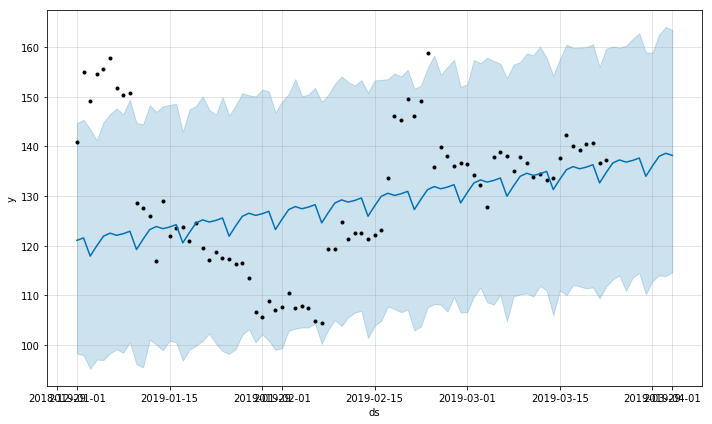

In [27]:
dt_restricted_prophet_plt(
    m = m,
    fcst = forecast,
    visible_window_start_dt = '01JAN2019',
    visible_window_end_dt = '01APR2019'
);

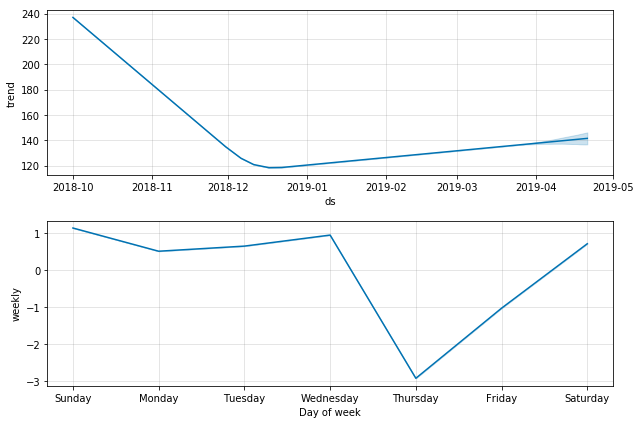

In [28]:
# Python
fig2 = m.plot_components(forecast)

In [29]:
%%capture
# capturing warnings here because one of the dependencies throws a bunch of numpy deprecation warnings

from fbprophet.diagnostics import cross_validation
df_dv = cross_validation(m, horizon = '30 days')

INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-01-06 00:00:00 and 2019-02-20 00:00:00


In [30]:
df_dv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-07,132.807929,107.898423,156.530809,151.70,2019-01-06
1,2019-01-08,133.783724,110.302860,158.324916,150.36,2019-01-06
2,2019-01-09,134.968383,108.713092,160.288673,150.80,2019-01-06
3,2019-01-10,131.154996,107.237231,155.471781,128.63,2019-01-06
4,2019-01-11,134.414339,110.478367,159.977961,127.55,2019-01-06


In [31]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_dv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
2,3 days,386.268865,19.653724,17.340861,0.125967,0.750000
63,4 days,357.625410,18.910986,16.069160,0.118123,0.750000
3,4 days,290.228841,17.036104,13.900363,0.103477,0.833333
93,4 days,289.257791,17.007580,13.861552,0.100887,0.833333
33,4 days,289.945733,17.027793,13.889329,0.101301,0.833333


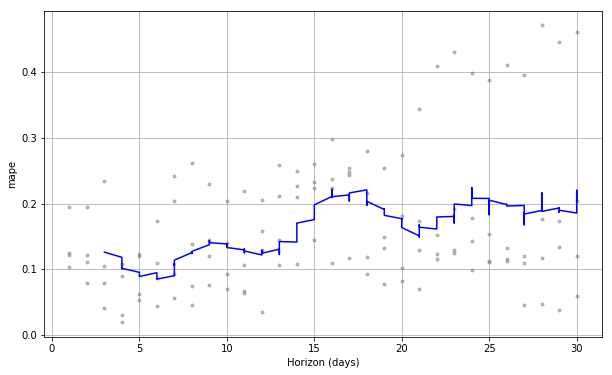

In [32]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_dv, metric = 'mape')